In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import scipy.ndimage as ndimage
from tqdm import tqdm_notebook
import community as cm
import networkx as nx
from collections import Counter
import pickle
from natsort import natsorted
from scipy.optimize import curve_fit

1133 5452


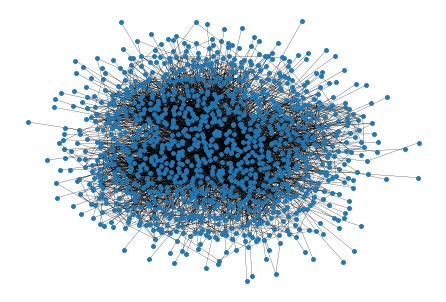

In [2]:
# g = nx.read_graphml('time_graphs/0/1500.graphml')
# g = nx.connected_watts_strogatz_graph(1500, 5, 0.15)
g = nx.read_edgelist('real_graphs/email.txt', data=False)
layout = nx.kamada_kawai_layout(g)

communities = nx.algorithms.community.centrality.girvan_newman(g)
print(g.number_of_nodes(), g.number_of_edges())
nx.draw(g, pos=layout, node_size=15, width=0.25)

In [3]:
levels = []
for com in tqdm_notebook(communities):
    levels.append(com)

In [4]:
levels = pickle.load(open('uvl_levels.pkl', 'rb'))

In [5]:
cluster_nodes = []
for i in "abcdefghijklmnopqrstuvwxyz":
    for j in "abcdefghijklmnopqrstuvwxyz":
        for k in "abcdefghijklmnopqrstuvwxyz":
            cluster_nodes.append(i + j + k)
            
dendro = nx.DiGraph()
dendro.add_node(tuple(g.nodes))

In [6]:
levels = [[tuple(sorted(x)) for x in sub] for sub in levels]
dendro.add_nodes_from(levels[0])
dendro.add_edges_from([(tuple(g.nodes), l) for l in levels[0]])

In [7]:
for i in range(len(levels) - 1):
    dendro.add_nodes_from(levels[i])
    split = list(set(levels[i]) - set(levels[i]).intersection(set(levels[i+1])))
    children = list(set(levels[i+1]) - set(levels[i]).intersection(set(levels[i+1])))
    dendro.add_edges_from([(split[0], c) for c in children])

2265 2264


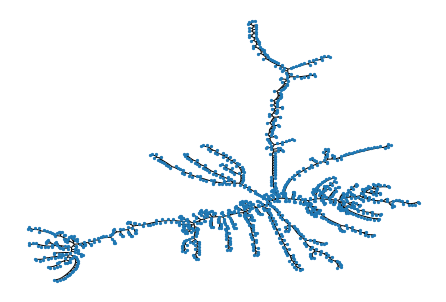

In [8]:
remap_dict = {}
counter = 0
draws = []
print(dendro.number_of_nodes(), dendro.number_of_edges())
for n in dendro.nodes:
    if len(n) > 1:
        remap_dict[n] = cluster_nodes[counter]
        counter += 1
    else:
        remap_dict[n] = n[0]
        draws.append(n[0])
        
remapped = nx.relabel_nodes(dendro, remap_dict)

nx.draw_kamada_kawai(nx.Graph(remapped), node_size=5, nodelist=draws)
plt.savefig('uvl_dendro.png', dpi=2160)

[0.46774889 0.70332943]
0.9926948600144481


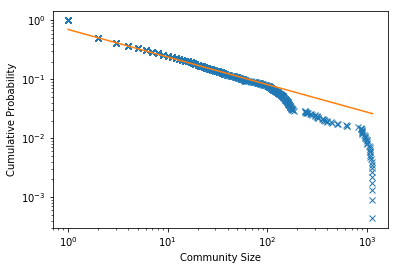

In [15]:
flattened = [x for y in levels for x in y]

flattened = list(set(flattened))

sizes = [len(x) for x in flattened]
sizes.append(g.number_of_nodes())

xs = sorted(sizes)
ys = [len([s for s in sizes if s >= m]) for m in xs]
ys = [y / len(sizes) for y in ys]

x_fits = xs[int(len(xs) * 0.5):]
y_fits = ys[int(len(ys) * 0.5):]

def hausdorff(lb, db, a):
    return a * lb**-db

popt = curve_fit(hausdorff, x_fits, y_fits)[0]
print(popt)

plt.xlabel('Community Size')
plt.ylabel('Cumulative Probability')
plt.xscale('log')
plt.yscale('log')
plt.plot(xs, ys, 'x')
curve_vals = [hausdorff(x, *popt) for x in xs]
plt.plot(xs, curve_vals)

y_fit = hausdorff(x_fits, *popt)

ss_res = np.sum((y_fits - y_fit) ** 2)

# total sum of squares
ss_tot = np.sum((y_fits - np.mean(y_fits)) ** 2)

# r-squared
r2 = 1 - (ss_res / ss_tot)
print(r2)

In [10]:
root = 'aaa'
nx.set_node_attributes(remapped, 0, 'hs')

# def compute_hs(node):
#     if not list(remapped.neighbors(node)):
#         remapped.node[node]['hs'] = 1
#     else:
#         children = list(remapped.neighbors(node))
#         if remapped.node[children[0]]['hs'] == 0:
#             compute_hs(children[0])
#         if remapped.node[children[1]]['hs'] == 0:
#             compute_hs(children[1])
#         if remapped.node[children[0]]['hs'] == remapped.node[children[1]]['hs']:
#             remapped.node[node]['hs'] = remapped.node[children[0]]['hs'] + 1
#         else:
#             remapped.node[node]['hs'] = max([remapped.node[children[0]]['hs'], remapped.node[children[1]]['hs']])
            
ratios = []
    
def compute_hs(node):
    if not list(remapped.neighbors(node)):
        ratios.append(1)
        return 1
    children = list(remapped.neighbors(node))
    if len(children) > 2:
        print(node, children)
        return
    l = children[0]
    r = children[1]
    
    if remapped.node[l]['hs'] == 0:
        remapped.node[l]['hs'] = compute_hs(l)
    if remapped.node[r]['hs'] == 0:
        remapped.node[r]['hs'] = compute_hs(r)
    
    if remapped.node[l]['hs'] == remapped.node[r]['hs']:
        ratios.append(remapped.node[r]['hs'] + 1)
        return remapped.node[r]['hs'] + 1
    return max([remapped.node[l]['hs'], remapped.node[r]['hs']])
            
remapped.node[root]['hs'] = compute_hs(root)
remapped.node[root]['hs']

5

5 1


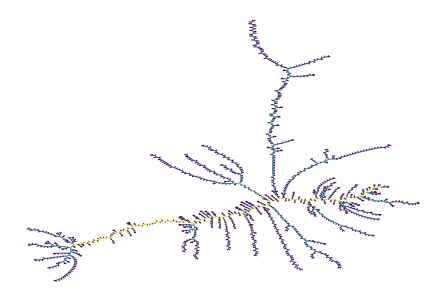

In [11]:
hs_colors = [min(remapped.node[e[0]]['hs'], remapped.node[e[1]]['hs']) for e in list(remapped.edges)]
print(max(hs_colors), min(hs_colors))

nx.draw_kamada_kawai(nx.Graph(remapped), node_size=0, nodelist=draws, edge_color=hs_colors, node_color='black')
plt.savefig('uvl_bifurcations.png', dpi=2160)

In [17]:
Counter(nx.get_node_attributes(remapped, 'hs').values())

Counter({5: 111, 2: 727, 3: 269, 4: 25, 1: 1133})

In [18]:
Counter(ratios)

Counter({1: 1133, 2: 181, 3: 32, 4: 7, 5: 1})

In [24]:
# vals = Counter(nx.get_node_attributes(remapped, 'hs').values())
vals = Counter(ratios)
bs = [vals[i+1] / vals[i+2] for i in range(len(vals) - 1)]

print(bs)
np.mean(bs), np.std(bs)

[6.259668508287293, 5.65625, 4.571428571428571, 7.0]


(5.871836769928966, 0.8889185661602808)

[7.0326242610280065, 5.198497031265826, 3.4657359027997265, 1.9459101490553132, 0.0]


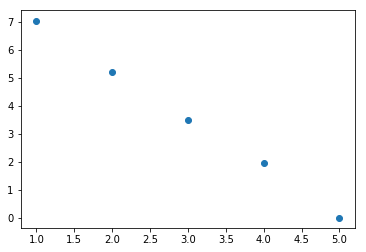

In [26]:
xs = list(Counter(ratios).values())
xs = [np.log(x) for x in xs]
print(xs)

plt.scatter(np.arange(1, len(xs) + 1), xs)

[1133, 181, 32, 7, 1]
[1187.2779576100002, 202.26200300000002, 34.456900000000005, 5.87, 1.0]


[]

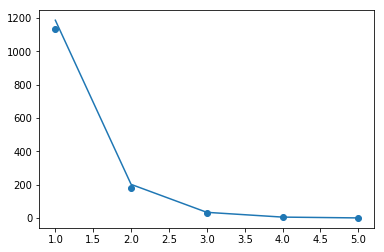

In [20]:
xs = list(Counter(ratios).values())
# xs = [np.log(x) for x in xs]

x2 = np.arange(1, len(vals) + 1)
y2 = [5.87 ** (5 - x) for x in x2]
print(xs)
print(y2)
# y2 = [v / 5.87 for v in reversed(sorted(vals.values()))]
# y2 = [np.log(y) for y in y2]

plt.scatter(np.arange(1, len(xs) + 1), xs)
plt.plot(x2, y2)
plt.plot()

[ 5.80428835 -3.40785981]
0.9998298615168336


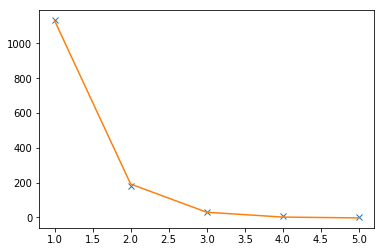

In [23]:
y3 = [np.log(x) for x in xs]
y3 = xs
x3 = np.arange(1, len(vals) + 1)

def hausdorff(x, b, a):
    return a + b ** (5-x)

popt = curve_fit(hausdorff, x3, y3)[0]
print(popt)

# plt.xscale('log')
# plt.yscale('log')
plt.plot(x3, y3, 'x')
curve_vals = [hausdorff(x, *popt) for x in x3]
plt.plot(x3, curve_vals)

y_fit = hausdorff(x3, *popt)

ss_res = np.sum((y3 - y_fit) ** 2)

# total sum of squares
ss_tot = np.sum((y3 - np.mean(y3)) ** 2)

# r-squared
r2 = 1 - (ss_res / ss_tot)
print(r2)

In [70]:
pickle.dump(levels, open('uvl_levels.pkl', 'wb'))